## 训练一个神经算子网络，并用以逆向求解问题
### 1.神经算子的训练
### 2.保存参数用以逆向求解

### 1.神经算子训练
为了直观理解，建立一个直观的映射，绘制出映射函数与被映射后的函数，以微分方程为例子。
简单起见，我们使用一个二阶微分方程
$$
\frac{\partial^2 S(x)}{\partial x^2}+\frac{\partial S(x)}{\partial x} + S(x) = u(x)  
$$

$$
S(0) = 0,\dot{S}(0)=0
$$


### 1.求解微分方程

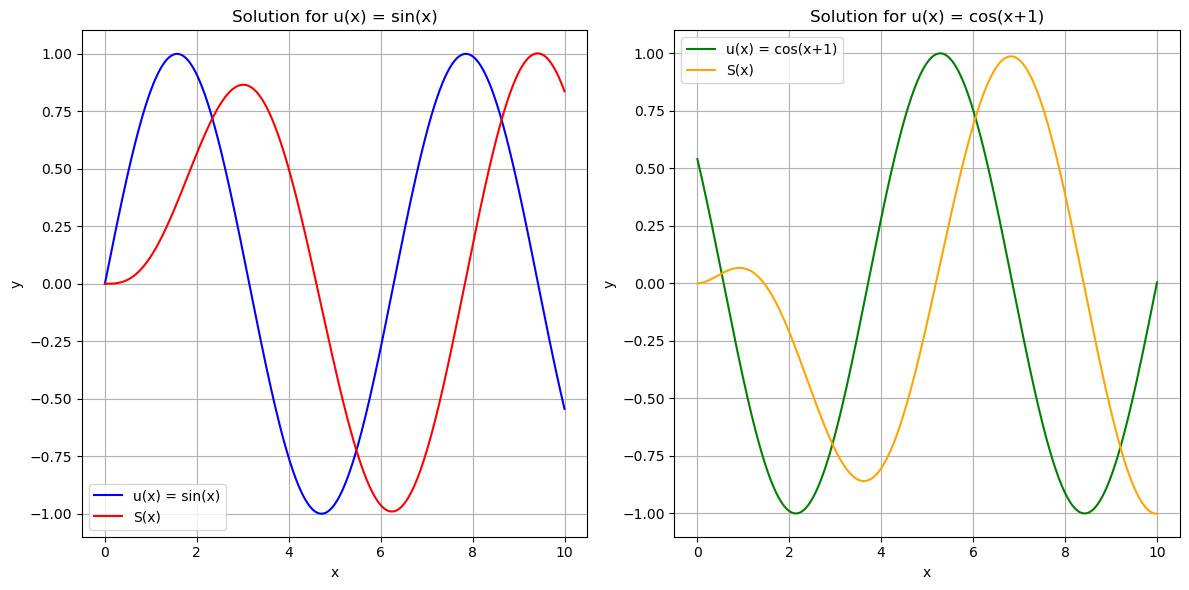

In [17]:
import numpy as np
import torch
import torchdiffeq
import matplotlib.pyplot as plt

# 定义 u(x) 函数
def u1(x):
    return torch.sin(x)

def u2(x):
    return torch.cos(x + 1)

# 定义微分方程的右边
def odefunc(t, y, u_func):
    y1, y2 = y
    dydt = torch.zeros_like(y)
    dydt[0] = y2
    dydt[1] = u_func(t) - y2 - y1
    return dydt

# 打包数据生成
def data_generate(odefunc, s0, s1, t_span, u_func):
    # 初始条件
    y0 = torch.tensor([s0, s1], dtype=torch.float32)  # 初始条件 S(0) = 0, S'(0) = 0

    # 使用 torchdiffeq 求解微分方程
    solution = torchdiffeq.odeint(lambda t, y: odefunc(t, y, u_func), y0, t_span, method='rk4')

    # 提取解
    S_values = solution[:, 0].detach().numpy()  # S(x) 对应 y1
    return S_values

# 设置求解区间
t_span = torch.linspace(0, 10, 1000)  # 求解区间 [0, 10]
s0 = 0  # 初始条件 S(0) = 0
s1 = 0  # 初始条件 S'(0) = 0

# 调用数据生成函数来计算 S(x)
S_values1 = data_generate(odefunc, s0, s1, t_span, u1)
S_values2 = data_generate(odefunc, s0, s1, t_span, u2)

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 第一个子图：u(x) = sin(x) 和 S(x)
axes[0].plot(t_span.numpy(), u1(t_span).numpy(), label="u(x) = sin(x)", color='b')
axes[0].plot(t_span.numpy(), S_values1, label="S(x)", color='r')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Solution for u(x) = sin(x)')
axes[0].legend()
axes[0].grid(True)

# 第二个子图：u(x) = cos(x+1) 和 S(x)
axes[1].plot(t_span.numpy(), u2(t_span).numpy(), label="u(x) = cos(x+1)", color='g')
axes[1].plot(t_span.numpy(), S_values2, label="S(x)", color='orange')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Solution for u(x) = cos(x+1)')
axes[1].legend()
axes[1].grid(True)

# 显示图形
plt.tight_layout()
plt.show()


## 测试生成取样函数

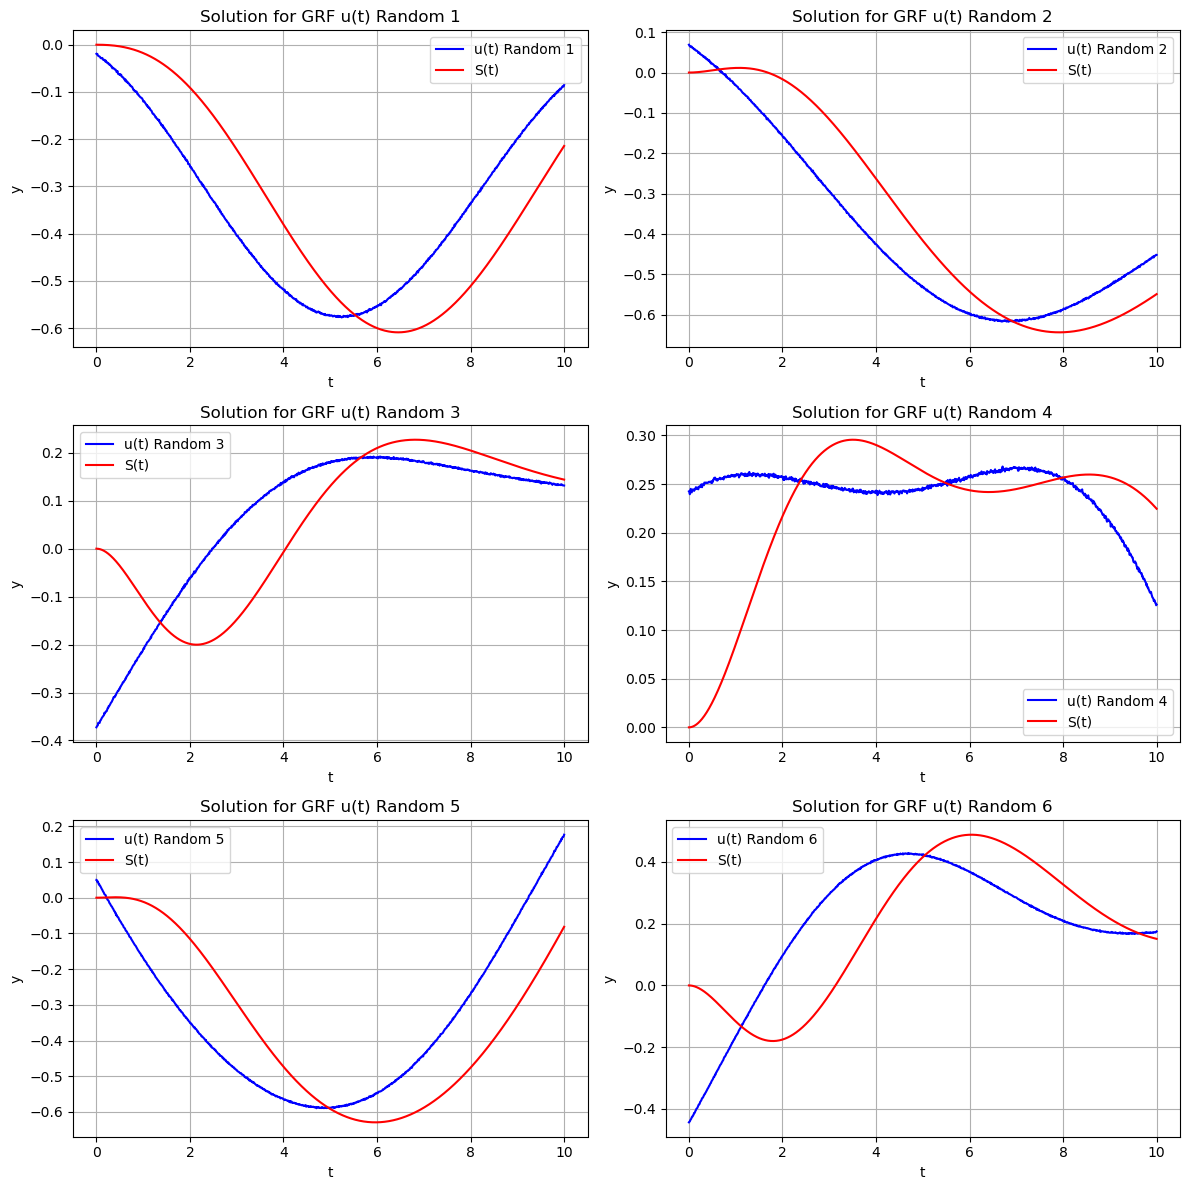

In [23]:
import numpy as np
import torch
import torchdiffeq
import matplotlib.pyplot as plt

# 生成高斯随机场 (Gaussian Random Field, GRF)
def generate_grf(t, length_scale=5.0, sigma=0.5, noise=1e-6):
    """
    Generate a Gaussian Random Field (GRF) sampled at points t.
    :param t: Input points (1D array or tensor)
    :param length_scale: Length scale of the RBF kernel
    :param sigma: Standard deviation of the Gaussian process
    :param noise: Noise added to the diagonal for numerical stability
    :return: A random function u(t) sampled at t
    """
    t = t.numpy() if isinstance(t, torch.Tensor) else t  # Ensure t is numpy for computation
    n = len(t)
    
    # Compute the covariance matrix using RBF kernel
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = sigma ** 2 * np.exp(-np.linalg.norm(t[i] - t[j]) ** 2 / (2 * length_scale ** 2))
    
    # Add a small noise term to the diagonal for numerical stability
    K += noise * np.eye(n)
    
    # Sample from multivariate Gaussian using Cholesky decomposition
    try:
        L = np.linalg.cholesky(K)  # Cholesky factorization
        u = np.dot(L, np.random.normal(size=n))  # Sample from N(0, K)
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix is not positive definite. Try increasing noise or adjusting length scale.")
    
    return torch.tensor(u, dtype=torch.float32)

# 定义微分方程的右边
def odefunc(t, y, u_func):
    y1, y2 = y
    dydt = torch.zeros_like(y)
    dydt[0] = y2
    dydt[1] = u_func(t) - y2 - y1
    return dydt

# 打包数据生成
def data_generate(odefunc, s0, s1, t_span, u_func):
    # 初始条件
    y0 = torch.tensor([s0, s1], dtype=torch.float32)  # Initial condition

    # 使用 torchdiffeq 求解微分方程
    solution = torchdiffeq.odeint(lambda t, y: odefunc(t, y, u_func), y0, t_span, method='rk4')

    # 提取解
    S_values = solution[:, 0].detach().numpy()  # S(x) 对应 y1
    return S_values

# 设置求解区间
t_span = torch.linspace(0, 10, 1000)  # Time domain [0, 10]
s0 = 0  # Initial condition S(0) = 0
s1 = 0  # Initial condition S'(0) = 0

# 创建子图
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3x2 subplot layout
axes = axes.flatten()  # Flatten axes for easy iteration

# 生成并求解多个 GRF 的 u(t)
for i in range(6):  # Generate 6 random u(t) functions
    # Generate random u(t) using GRF
    u_func_values = generate_grf(t_span, length_scale=5.0, sigma=0.5, noise=1e-6)  # Adjust length_scale and sigma as needed

    # Define u_func as an interpolating function for ODE solver
    def u_func(t):
        idx = (torch.abs(t - t_span)).argmin()  # Find the closest index
        return u_func_values[idx]

    # Solve ODE
    S_values = data_generate(odefunc, s0, s1, t_span, u_func)

    # Plot u(t) and S(t)
    axes[i].plot(t_span.numpy(), u_func_values.numpy(), label=f"u(t) Random {i+1}", color='b')
    axes[i].plot(t_span.numpy(), S_values, label=f"S(t)", color='r')
    axes[i].set_xlabel('t')
    axes[i].set_ylabel('y')
    axes[i].set_title(f"Solution for GRF u(t) Random {i+1}")
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


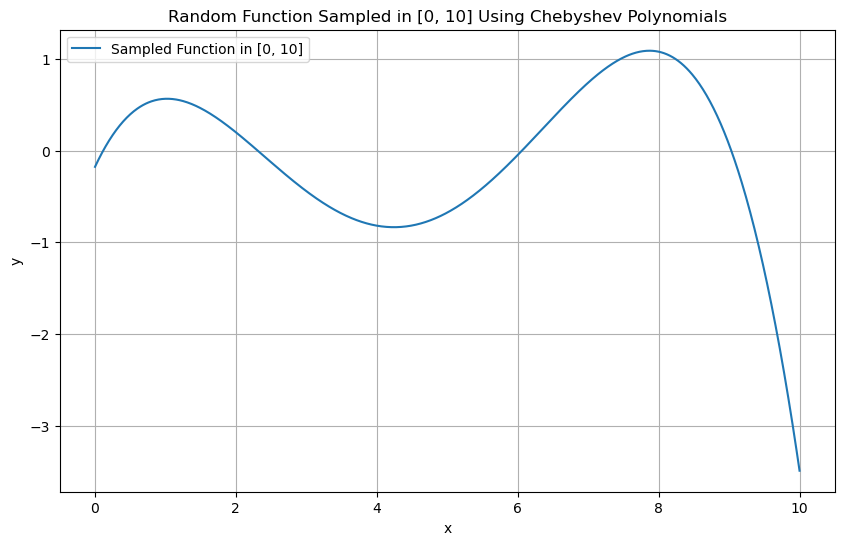

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 定义切比雪夫多项式函数
def chebyshev_poly(n, x):
    """
    Compute the n-th Chebyshev polynomial T_n(x)
    :param n: Degree of the polynomial
    :param x: Input values in [-1, 1]
    :return: T_n(x)
    """
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x
    else:
        T0 = np.ones_like(x)
        T1 = x
        for k in range(2, n + 1):
            T_next = 2 * x * T1 - T0
            T0 = T1
            T1 = T_next
        return T1

# 定义域的线性映射
def map_to_standard_domain(x, a, b):
    """
    Map x from [a, b] to [-1, 1]
    :param x: Input values in [a, b]
    :param a: Lower bound of the original domain
    :param b: Upper bound of the original domain
    :return: Mapped values in [-1, 1]
    """
    return 2 * (x - a) / (b - a) - 1

def map_to_original_domain(x_prime, a, b):
    """
    Map x' from [-1, 1] to [a, b]
    :param x_prime: Input values in [-1, 1]
    :param a: Lower bound of the target domain
    :param b: Upper bound of the target domain
    :return: Mapped values in [a, b]
    """
    return 0.5 * (x_prime + 1) * (b - a) + a

# 在任意定义域上采样函数
def sample_function_in_new_domain(x, a, b, max_degree=5, coeff_range=(-1, 1)):
    """
    Sample a random function in the new domain [a, b] using Chebyshev polynomials.
    :param x: Input points in [a, b]
    :param a: Lower bound of the original domain
    :param b: Upper bound of the original domain
    :param max_degree: Maximum degree of the Chebyshev polynomial
    :param coeff_range: Range of the random coefficients for the polynomials
    :return: Function values sampled at x
    """
    # Map x to the standard domain [-1, 1]
    x_prime = map_to_standard_domain(x, a, b)
    
    # Randomly sample coefficients for Chebyshev polynomials
    coeffs = np.random.uniform(coeff_range[0], coeff_range[1], size=max_degree)
    
    # Compute the function values using Chebyshev polynomials
    y = np.zeros_like(x_prime)
    for n in range(max_degree):
        y += coeffs[n] * chebyshev_poly(n, x_prime)
    
    return y

# 绘图函数
def plot_sampled_function(a, b, max_degree=5, coeff_range=(-1, 1), num_points=1000):
    """
    Plot a sampled random function in the new domain [a, b].
    :param a: Lower bound of the domain
    :param b: Upper bound of the domain
    :param max_degree: Maximum degree of the Chebyshev polynomial
    :param coeff_range: Range of the random coefficients for the polynomials
    :param num_points: Number of points to sample in the domain
    """
    # Generate points in the domain [a, b]
    x = np.linspace(a, b, num_points)
    
    # Sample the function
    y = sample_function_in_new_domain(x, a, b, max_degree=max_degree, coeff_range=coeff_range)
    
    # Plot the function
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f"Sampled Function in [{a}, {b}]")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Random Function Sampled in [{a}, {b}] Using Chebyshev Polynomials")
    plt.legend()
    plt.grid(True)
    plt.show()

# 示例使用
if __name__ == "__main__":
    # 定义域 [0, 10]
    a, b = 0, 10
    max_degree = 5
    coeff_range = (-1, 1)
    plot_sampled_function(a, b, max_degree=max_degree, coeff_range=coeff_range)
